fuel model - penalizes for too low and to high velocities due to air resistance

fuel obj-  fuel-velocity , change in velocity, fuel consumed while stopping until you reach destination

multiple traffic lights

traffic - 
show - draw a diagram of the position and time of the vehicle, and the time bars for the red lights 

analysis - savings in fuel

---------------------------------------------------
limit for the acceleration max and min for stopping also 
minimizing fuel consumption only right now 
minimize jerk 
acceleration, derivative of acceleration 

quadratic speed decrease 

not consuming fuel when you hit breaks
current velocity plus current acceleration 

higher gears are more efficient 60miles per hour
discrete problem, for different gears different fuel efficiency 

is it different for truck or a car ? 

keep model simplified and add traffic lights 


In [118]:
start_x = 0
destination = 800     # meters
idle_fuel = 0.1/3600  # gallon per second
min_v = 6             # m/s
max_v = 19

min_a = -5
max_a = 5

n_lights = 3
traf_pos = [300, 500, 700]  # meters

T = 180                     # seconds; upper bound 
t = [1:T;]

t_green_duration = [10, 10, 10]
t_red_duration = [24, 24, 24]

t_g = Array{Int64, 2}(n_lights, T)
t_r = Array{Int64, 2}(n_lights, T)

# generating arrays for traffic light phases, assumption starts with red light 
for k = 1:size(t_g, 1)
    for i=1:T
        j = i%(t_red_duration[k] + t_green_duration[k])
        if j<=(t_red_duration[k]-1)
            t_g[k, i] = t_red_duration[k] - j + 1
            t_r[k, i] = 0
        else
            t_g[k, i] = 0
            t_r[k, i] = t_green_duration[k] - j + t_red_duration[k]
        end
    end
end


# fuel piecewise values 
v_end_point = [8, 8, 15]
v_func = [0.7, 0.7, 0.7]
l_sign = [-1, 1, 1]
g = [-13/20, 0, 3/40];

In [115]:
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))
@variable(m, x[1:T] >=0 )               # position at time t
@variable(m, 0 <= v[1:T] <= max_v)      # velocity at time t
@variable(m, min_a <= a[1:T-1] <= max_a)       # acceleration at time t 
#@variable(m, obj_t[1:T])                # epigraph variable for fuel piecewise linear function 
@variable(m, obj_fuel[1:T] >= 0)  
@variable(m, w[1:T-1])
@variable(m, w_a[1:T-2])
@variable(m, z_1[1:n_lights, 1:T], Bin)   # iff z1=1 then x[i] >= 965
@variable(m, z_2[1:n_lights, 1:T], Bin)   # iff z2=1 then x[i] <= 965
@variable(m, z_3[1:n_lights, 1:T], Bin)   # if z1=1 and z2=1 then z3 = 1; i.e. x[i] == 965
@variable(m, z_7[1:n_lights, 1:T], Bin)   # if x[i]>=946 then z7=1
@variable(m, z_8[1:n_lights, 1:T], Bin)   # if x[i]<=965 then z8=1
@variable(m, z_9[1:n_lights, 1:T], Bin)   # if z7=1 and z8=1 then z9=1
@variable(m, z_10[1:T], Bin)              # if v[i]<=0 then z_10 = 1

@variable(m, z_11[1:T], Bin)              # if x[i]<=destination then z_11 = 1
@variable(m, z_12[1:T], Bin)              # if x[i]<=destination (z_11=1) and v[i]==0 (or z_10=1)then z_12 = 1

@variable(m, z_p[1:T,1:3], Bin)
@variable(m, lambda[1:T,1:3] >= 0)

@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # per second, x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # per second, v = v_initial + at 
@constraint(m, x[T] == destination)     # we need to reach destination 
@constraint(m, x[1] == start_x)
@constraint(m, v[1] == 0)
@constraint(m, v[T] == 0) 
#@constraint(m, x[2] >= x[1] + 0.001)

# piecewise linear function for fuel 
#@constraint(m, fuel_lin1[i in 1:T], obj_t[i] >= 0.1*(-13/2*v[i]+59))
#@constraint(m, fuel_lin2[i in 1:T], obj_t[i] >= 0.1*7)
#@constraint(m, fuel_lin3[i in 1:T], obj_t[i] >= 0.1*(3/4*v[i]-17/4))


# constraints to ensure choosing two consecutive end points of segments
#@constraint(m, lambda[1] <= z_p[1])
#@constraint(m, lambda[3] <= z_p[3])
#@constraint(m, lambda[2] <= z_p[1] + z_p[2])
#@constraint(m, lambda[2] <= 7)
for i in 1:T
    @constraint(m, lambda[i,1] <= 8*z_p[i,1])
    @constraint(m, lambda[i,3] <= 4*(z_p[i,2] + z_p[i,3]))
    @constraint(m, lambda[i,2] <= 7*(z_p[i,2] + z_p[i,1]))
    #@constraint(m, sum(z_p[i,j] for j=1:2) == 1)
    @constraint(m, sum(lambda[i,:]) <= 4+7+8)
end

@expression(m, obj_t[i in 1:T], sum(z_p[i,j]*v_func[j] + l_sign[j]*g[j]*lambda[i,j] for j=1:3))
@expression(m, v_value[i in 1:T], sum(z_p[i,j]*v_end_point[j] + l_sign[j]*lambda[i,j] for j=1:3))
for i in 1:T                                    
    @constraint(m, v_value[i] == v[i])
end 
                                    
                                    
for i=1:T-1
    @constraint(m, w[i] >= a[i])
    @constraint(m, -w[i] <= a[i])
end

for i=1:T-2
    @constraint(m, w_a[i] >= a[i+1]-a[i])
    @constraint(m, -w_a[i] <= a[i+1]-a[i])
end

# Constraints for near the traffic light
for k = 1:n_lights
    for i=1:T
        @constraint(m, x[i] - (traf_pos[k]-max_v) <= traf_pos[k]*2*z_7[k, i] - 0.1*(1-z_7[k, i]))
        @constraint(m, x[i] - (traf_pos[k]-max_v) >= -(traf_pos[k]-max_v)*(1-z_7[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) >= -(traf_pos[k])*z_8[k, i] + 0.1(1-z_8[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) <= traf_pos[k]*2*(1-z_8[k, i]))
        @constraint(m, z_7[k, i] + z_8[k, i] - 2 <= 2*z_9[k, i] - (1-z_9[k, i]))
        @constraint(m, z_7[k, i] + z_8[k, i] - 2 >= -2*(1-z_9[k, i]))

        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*z_1[k, i] - (1-z_1[k, i]))  # constraints for checking if x[i]==end_x
        @constraint(m, x[i] - traf_pos[k] >= -traf_pos[k]*(1-z_1[k, i]))
        @constraint(m, x[i]- traf_pos[k] >= -traf_pos[k]*z_2[k, i] + (1-z_2[k, i]))
        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*(1-z_2[k, i])) 
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 <= 2*z_3[k, i] - (1-z_3[k, i]))
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 >= -2*(1-z_3[k, i]))

        for j=i:i+t_g[k, i]

            if j<=T
                @constraint(m, x[j]-(traf_pos[k]) <= 2*(traf_pos[k])*(1-z_9[k, i])) # if z9=1 then x[i+1] ... x[i+t_g[i]<=end_x
                @constraint(m, v[j] <= max_v*(1-z_3[k, i]))                # if z3=1 then v[j] = 0, last speed =0 when stops
            end
        end

        if k==1 && i>=2 && i <= T-1
            @constraint(m, v[i] >= -0.1*z_10[i]+(1-z_10[i]))
            @constraint(m, v[i] <= max_v*(1-z_10[i]))
        end
    end
end

for i=1:T
    @constraint(m, x[i] - (destination-0.01) >= -(destination-0.01)*z_11[i] + 0.01(1-z_11[i])) # if x<=dest-0.01 then z_11==1
    @constraint(m, x[i] - (destination-0.01) <= destination*2*(1-z_11[i]))  # if z_11=1 then x<= dest-0.01
end
                                    
for i=1:T
    @constraint(m, sum(z_p[i,:]) <= z_11[i]) # if z_11==0 then sum(z_p)<=0
    @constraint(m, sum(z_p[i,:]) >= z_11[i]) # if z_11==0 then sum(z_p)>=0
    @constraint(m, sum(z_p[i,:])-1 >= -1(1-z_11[i])) # if z_11==1 then sum(z_p)>=1
    @constraint(m, sum(z_p[i,:])-1 <= -1(1-z_11[i])) # if z_11==1 then sum(z_p)<=1                        
end

# Objective function: 
# 1) minimize fuel only until traffic light (z_8=1 if x[i]<=965)
# 2) minimize change in velocities until traffic light 
# 3) idle time: sum all the cases when v[i]==0
# 4) change in acceleration 

#@objective(m, Min, sum(obj_t) + sum(w) + sum(z_10)*idle_fuel + sum(w_a))
@objective(m, Min, sum(obj_t) + sum(w) + sum(w_a))

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)

println(getobjectivevalue(m))
#=
for i=1:T
    if xopt[i] >= 296 && xopt[i] <= 302
        println(t_g[1, i], " T_GGG")
    end
    if xopt[i] >= 694 && xopt[i] <= 702
        println(t_g[3, i], " T_GGG")
    end
end
=#
#println("z11:", getvalue(z_11))
#println()
println(getvalue(obj_t))
println(getvalue(z_p))
println(getvalue(lambda))


167.62551858320273
[5.9,3.3,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.877273,1.05455,1.23182,1.40909,1.58636,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.61893,1.52703,1.43514,1.34325,1.25136,1.15946,1.06757,0.975678,0.883785,0.791893,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,1.96937,3.93468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[1.0 0.0 0.

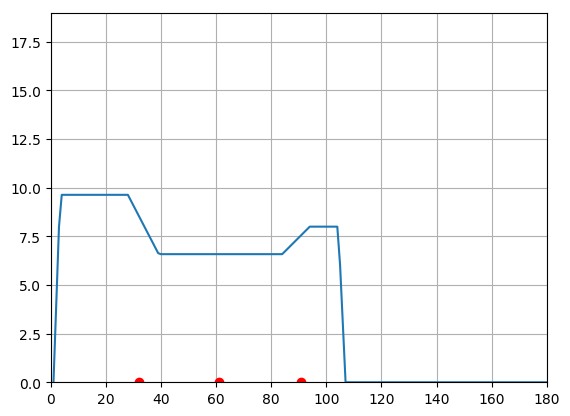

[32.0,61.0,91.0]


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32bb80910>

In [116]:
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt)

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
println(time_at_light)
plot(time_at_light, zeros(n_lights), "ro")

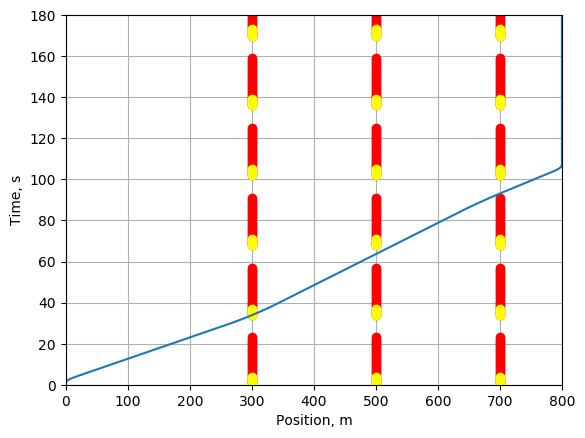

PyObject <matplotlib.text.Text object at 0x32d1b6610>

In [117]:
# Plot of Position vs Time (includes waiting time's position)
xlim(0,destination+100)

t_lights = zeros(n_lights, T)
t_yellow = zeros(n_lights, T)

for k=1:n_lights
    count = 0
    for i=1:T
        if t_r[k,i]==0
            if count < 4
                t_yellow[k,i] = i
            end
            count = count + 1
            t_lights[k,i] = i
        else
            count = 0
        end
    end
end

traf_pos_x = zeros(n_lights, T)
for k=1:n_lights
    for i in 1:T
        traf_pos_x[k,i] = traf_pos[k]
    end
end
for k=1:n_lights
    plot(traf_pos_x[k,:], t_lights[k,:], "ro")
    plot(traf_pos_x[k,:], t_yellow[k,:], color="yellow", marker="o", linestyle="None")
end
plot(xopt,t)
ylim(0, T)
xlim(0, destination)
grid("on")
xlabel("Position, m")
ylabel("Time, s")

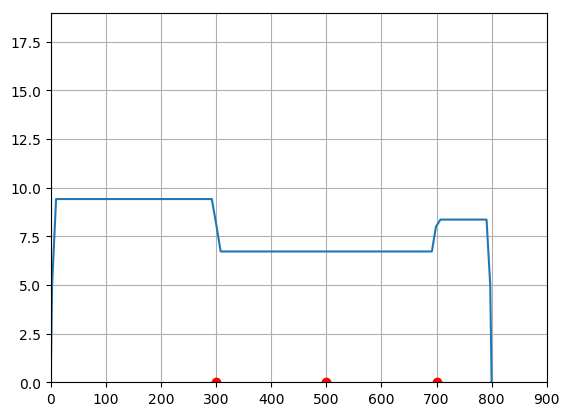

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32c102190>

In [114]:
plot(xopt, vopt)
grid("on")
ylim(0,max_v)
xlim(0, destination+100)
plot(traf_pos, zeros(n_lights), "ro")

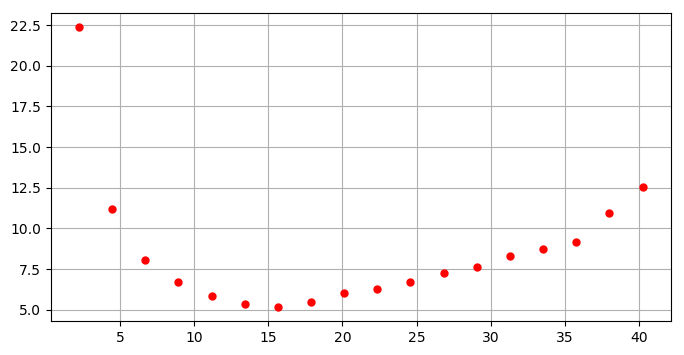

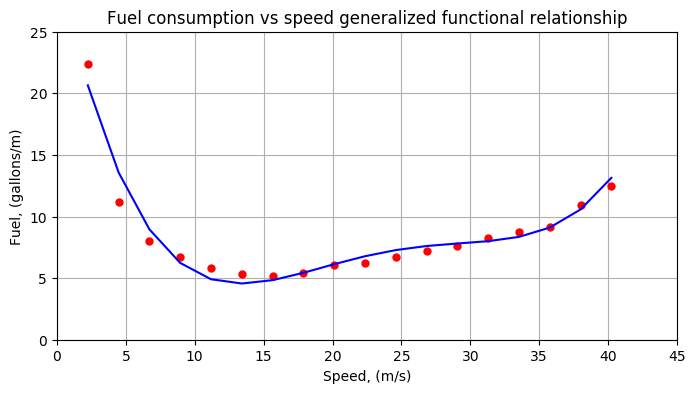

[0.000111703,-0.0108393,0.376853,-5.32999,30.7955]


In [11]:
# define (x,y) coordinates of the points
x_m = [ 5,  10, 15, 20, 25, 30, 35,   40,   45,   50,   55,   60,   65,   70,   75, 80, 85, 90 ]
y_m = [ 50, 25, 18, 15, 13, 12, 11.5, 12.2, 13.5, 14,   15,   16.2,   17,   18.5,   19.5, 20.5, 24.5, 28 ]
x = 0.44704 .* x_m
y = 0.44704 .* y_m

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
#xlim([0,10]); 
#ylim([0,55])
grid("on")
# order of polynomial to use
k = 4

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

# NOTE: must have either Gurobi or Mosek installed!

using JuMP, Gurobi, Mosek

#m = Model(solver=MosekSolver(LOG=0))
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
solve(m)
uopt = getvalue(u)
println(uopt)

using PyPlot
npts = length(x)
xfine = x #linspace(1,90,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
xlabel("Speed, (m/s)")
ylabel("Fuel, (gallons/m)")
title("Fuel consumption vs speed generalized functional relationship")
xlim(0,45)
ylim(0,25)
grid("on")
#xlim([0,10]); 
#ylim([0,55]); grid()

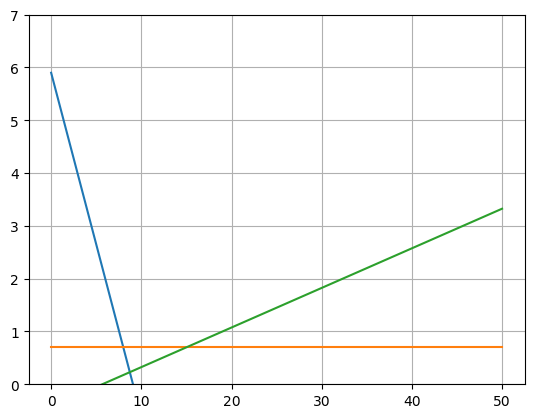

(0,7)

In [56]:
using PyPlot
v = [0:50;]
d = zeros(51)
for i=1:51
    d[i] = 7*0.1
end
plot(v, 0.1(-13/2.*v+59))
plot(v,d)
plot(v, 0.1(3/4.*v-17/4))
grid("on")
ylim(0,7)
xlim(0,)

1) consider two cases for the green lights: starts with green and then starts with red 

2) fix objective value 

3) report 